In [1]:
import numpy as np
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import losses
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import joblib
from pandas import DataFrame
import xlsxwriter

ct_sheet = pd.ExcelFile("Training Data.xlsx") 

Using TensorFlow backend.


C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mattbeze\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(290, 148)
(290, 148)
Tensor("input_1:0", shape=(None, 148), dtype=float32)
Train on 261 samples, validate on 29 samples
Epoch 1/150
261/261 [==============================] - 1s 4ms/step - loss: 0.2615 - val_loss: 0.1551
Epoch 2/150
261/261 [==============================] - 0s 337us/step - loss: 0.1602 - val_loss: 0.1411
Epoch 3/150
261/261 [==============================] - 0s 337us/step - loss: 0.1495 - val_loss: 0.1358
Epoch 4/150
261/261 [==============================] - 0s 341us/step - loss: 0.1424 - val_loss: 0.1401
Epoch 5/150
261/261 [==============================] - 0s 326us/step - loss: 0.1392 - val_loss: 0.1317
Epoch 6/150
261/261 [==============================] - 0s 345us/step - loss: 0.1366 - val_loss: 0.1299
Epoch 7/150
261/261 [==============================] - 0s 349us/step - loss: 0.1355 - val_loss: 0.1347
Epoch 8/150
261/261 [==============================] - 0s 345us/step - loss: 0.1378 - val_loss: 0.1348
Epoch 9/150
261/261 [==============================] - 0s

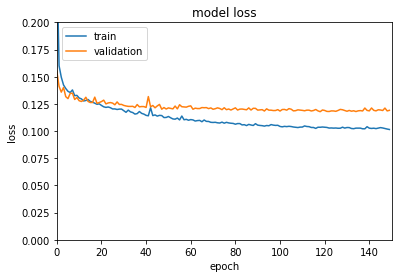

In [2]:
parsee = ct_sheet.sheet_names[2]
data = ct_sheet.parse(parsee)
data_features = data.loc[:, data.columns] 
data_features = data_features.drop(['ROI',11142,12142], axis=1)  

parsee2 = ct_sheet.sheet_names[3]
data2 = ct_sheet.parse(parsee2)
data_labels = data2.loc[:, data2.columns] 
data_labels = data_labels.drop(['ROI',11142,12142], axis=1)  
#Get rid of subject names to only have features now. #Need to remove ROIs. They don't convert to floats.
#Get rid of ctx_rh_Medial_wall and ctx_lh_Medial_wall, not needed for analysis.
#Have to standardize data. Scikit learn here. Need to create stratified K folds to avoid uneven distribution of risk groups.pcaCT1Y = PCA(n_components=150) #150 Features
scaler_filename = "IBIS_scaledSA1y.save"
scaler = joblib.load(scaler_filename)
scaled_data_1y = scaler.transform(data_features)

scaler_filename2 = "IBIS_scaledSA2y.save"
scaler2 = joblib.load(scaler_filename2)
scaled_data_2y = scaler.transform(data_labels)
print(scaled_data_1y.shape)
print(scaled_data_2y.shape)
#X_train, X_test, Y_train, Y_test = train_test_split(scaled_data, scaled_labels, test_size=0.10, random_state=20)
X_train, X_test, Y_train, Y_test = train_test_split(scaled_data_1y, scaled_data_2y, test_size=0.10, random_state=20)
#Size of encoded representation
#{'batch_size': 10, 'dropout': 0.15, 'encoded_layer_size': 25, 'epochs': 150, 'layer1_size': 100, 'layer2_size': 40}
input_size = 148
hidden_size = 100 #100
hidden_size_2 = 40 #40
encoding_dim = 25 #25
dropout = 0.15
#Increase layer size
# Input Placeholder
input_data = Input(shape=(input_size,))
print(input_data)
# "encoded" is the encoded representation of the input
hidden_e_1 = Dense(hidden_size, activation='tanh')(input_data) 
hidden_e_2 = Dense(hidden_size_2, activation='tanh')(hidden_e_1)
dropout_layer = Dropout(dropout)(hidden_e_2)
encoded = Dense(encoding_dim, activation='tanh')(dropout_layer)
# "decoded" is the lossy reconstruction of the input
hidden_d_1 = Dense(hidden_size, activation='tanh')(encoded)
dropout_layer_d = Dropout(dropout)(hidden_d_1)
hidden_d_2 = Dense(hidden_size, activation='tanh')(dropout_layer_d)
decoded = Dense(input_size, activation='tanh')(hidden_d_2) 
# this model maps an input to its prediction
autoencoder = Model(input_data, decoded)
# configure our model to use mean_absolute_error loss function, and the Adam optimizer:
autoencoder.compile(optimizer='Adam', loss='mean_absolute_error')

ac = autoencoder.fit(X_train, Y_train,
epochs=150,
batch_size=10,
validation_data=(X_test, Y_test),
shuffle=True)

#print(ac.history.keys())
# "Loss"
plt.plot(ac.history['loss'])
plt.plot(ac.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.legend(['train'], loc='upper left')
plt.axis([0, 150, 0.0, 0.2])
plt.show()

In [3]:
print(Y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_test.shape)

(261, 148)
(261, 148)
(29, 148)
(29, 148)


In [4]:
autoencoder.save("Autoencoder Input 1 year Output 2 year SA")

In [5]:
#Now calculate MAE on the original Gilmore Dataset
#Input
sa_sheet_2y = pd.ExcelFile("Scaled Gilmore Data for MAE.xlsx") 
parsee = sa_sheet_2y.sheet_names[1]
print(parsee)
data = sa_sheet_2y.parse(parsee)
data_features_sa2y = data.loc[:, data.columns] 
data_features_sa2y = data_features_sa2y.drop(['ROI'], axis=1)
#Ground truth
sa_sheet_1y = pd.ExcelFile("Scaled Gilmore Data for MAE.xlsx") 
parsee = sa_sheet_1y.sheet_names[0]
print(parsee)
data = sa_sheet_1y.parse(parsee)
data_features_sa1y = data.loc[:, data.columns] 
data_features_sa1y = data_features_sa1y.drop(['ROI'], axis=1)

#Predict
predicted_2yr_sa = autoencoder.predict(data_features_sa1y)
truth_2yr_sa = data_features_sa2y.to_numpy()

#Save
#y_pred = pd.DataFrame(predicted_1yr_sa_gilmore)

from sklearn.metrics import mean_absolute_error
print('MAE 2y AC {} '.format(mean_absolute_error(truth_2yr_sa, predicted_2yr_sa)))


######Complete below

SA2y
SA1y
MAE 2y AC 0.23384510976405568 


In [6]:
sa_sheet_1y = pd.ExcelFile("Data to be Interpolated.xlsx") 
parsee = sa_sheet_1y.sheet_names[4]
print(parsee)
data = sa_sheet_1y.parse(parsee)
data_features_sa1y = data.loc[:, data.columns] 
data_features_sa1y = data_features_sa1y.drop(['ROI'], axis=1)

print(data_features_sa1y.shape)

predicted_2yr_sa = autoencoder.predict(data_features_sa1y)
df = pd.DataFrame(predicted_2yr_sa)
df.to_excel("Interpolated SA 2y.xlsx", index=False)

1Y SA Scaled
(36, 148)
